# Advent of Code

In [ ]:
%pip install z3
%conda install requests

In [2]:
from matplotlib import pyplot as plt, animation
from matplotlib import cm, colors
from mpl_toolkits.mplot3d import Axes3D

import numpy as np
from IPython.display import YouTubeVideo


%matplotlib notebook

Advent of Code je kombinacija adventskih kalendara i programskih zadataka. :)
U vrijeme adventa (točnije 1.12 - 25.12), na stranici *[adventofcode.com](https://adventofcode.com)* objavljuje se programski zadatak, točno kao adventski kalendari (ali bez čokoladica :( ). Svaki zadatak otkriva dio sličice za tu godinu. Svaka godina ima smiješnu pricu sa vilenjakom koji spašava Božic od svakakvih opasnosti i sa svakim zadatkom mi pomažemo vilenjaku.
Advent of Code je veoma koristan za učenje novog jezika, učenje struktura podataka i algoritama, pripreme za intervjue.

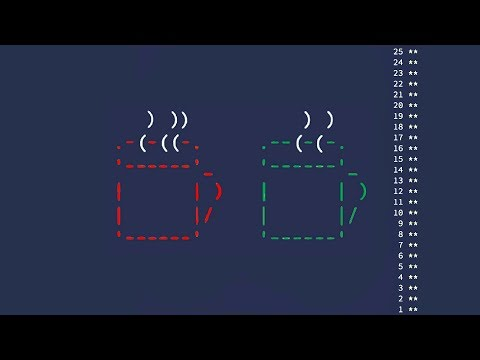

In [3]:
YouTubeVideo('CFWuwNDOnIo', width=800, height=300)

Definitivno preporučam da pogledate video u kojem tvorac Advent of Code-a bolje objašnjava što je advent of code i kako je nastao.

U ovom eseju ću riješiti nekoliko zadataka iz Advent of Code-a za koje mislim da su zabavni i koji bi mogli biti veoma korisni za nekog tko nije probao riješiti ovakvu vrstu zadataka.

## Generalne upute

### rješenja zadataka

Advent of Code zadatci zahtjevaju nekakav login da bi se rješenja zadataka mogla potvrditi. Preporučam da napravite svoj account i pokušate riješiti neke zadatke. Ako to ne želite, u file-u creds.txt postoji gmail account i password sa kojim se možete ulogirati i provijeriti zadatke.

### Upute za preuzimanje zadataka

Posjetiti stranicu *[Advent of Code](https://adventofcode.com)*. Na toj stranici napraviti acconut (može se koristiti github/email) i kopirati svoj session. Pozvati fju `get_aoc_input` sa `session_str` jednakim session-u i danom i godinom zadatka.

Za naći session morate: otvoriti advent of code, desni klik -> inspect, otvoriti karticu `storage`, kliknuti `Cookies` i kopirati string koji se nalazi u polju session.

### Animacije

U ovom notebook-u imam dvije animacije. Ne mogu se vrtiti obije u isto vrijeme, tako da ako pokrenete `Run All`, morat će te ručno pokrenut prvu animaciju (nalazi se u odjeljku `Smoke basin`), pa onda ručno pokrenuti drugu animaciju (zadnja sličica u notebook-u).

In [4]:
session = '53616c7465645f5fa84cdf4fd1e667823de36970c380c49a1373a1ac0d5a4ddf77aeb87eda22f992bac9a4e24fa8295f06c385916e074b59f6ba4ee8e53b2612'

In [5]:
import requests
import os

def get_aoc_input(session_str, day, year, return_output=False):
    
    if os.path.exists(f'./{year}_{day}_input.txt'):
        with open(f'{year}_{day}_input.txt') as f:
            text = [x.strip() for x in f.readlines()]
        if return_output: return text
    else:
        response = requests.get(
            f'https://adventofcode.com/{year}/day/{day}/input',
            headers={'cookie':f'session={session_str}'}
        )
    
        try:
            with open(f'{year}_{day}_input.txt', 'w') as f:
                f.write(response.text.strip())
            if return_output: return [x.strip() for x in response.text.strip().split('\n')]
        except Exception as e:
            print(f'Error: {e.args}')
            return None

## Lanternfish

*[Link na zadatak](https://adventofcode.com/2021/day/6)*

Ajmo riješiti nešto relativno jednostavno kao prvi zadatak :).
Evo tldr ako niste pročitali zadatak sa stranice.
Imamo neke ribice i neka pravila kako nastaju nove ribice. Svaka ribica ima timer koji pokažuje koliko iteracija treba da bi nova ribica nastala iz trenutne. Input nam je lista brojeva koja predstavlja ribice i koliko vremena imaju do dupliciranja. Nakon dupliciranja, novoj ribici se timer postavlja na 8, a staroj na 6. Mi trebamo izračunati koliko ribica imamo nakon 80 iteracija.

In [6]:
from collections import deque
import re
import itertools as it

In [7]:
get_aoc_input(session, 6, 2021)

Razmišlimo što se traži od nas. Imamo niz brojeva koji predstavljaju ribice. Trebaju nam dva niza, jedan sa trenutnom generacijom i jedan sa novom generacijom. Svaki put kada broj dođe do 0, dodajemo novu ribicu u niz sa novom generacijom (sa brojem 8), a trenutnu ribicu stavljamo na 6 u trenutnom nizu. Nakon svake iteracije spojimo dva niza. To napravimo 80 puta i gotov zadatak.

In [8]:
with open('2021_6_input.txt') as f:
    inlist = list(map(int, f.readline().strip().split(',')))
    
for _ in range(80):
    new_gen = []
    for i,num in enumerate(inlist):
        if num == 0:
            inlist[i] = 6
            new_gen.append(8)
        else:
            inlist[i] -= 1
    inlist += new_gen
print(len(inlist))

362346


Veoma jednostavno :)

Sidenote za one koji nisu pogledali video. U adventu svaki zadatak ima 2 podzadatka. Obično vrijedi da se u prvom zadatku implementira dio funkcionalnosti, a u drugom se koristi ili modificira prvi dio zadatka. Nekada se zna dogoditi (foreshadowing) da poštoji konkretna ideja na koju autor zadatka cilja i nerijetko se dogodi da se prvi podzadatak mora reimplementirati nakon što se pročita drugi podzadatak.

Paaa, ajmo pročitat drugi podzadatak.

```
Suppose the lanternfish live forever and have unlimited food and space. Would they take over the entire ocean?

After 256 days in the example above, there would be a total of *26984457539* lanternfish!

How many lanternfish would there be after *256* days?
```

Ajoj.......

Ovo raste eksponencijalno....
Ako pokušamo samo promijeniti 80 u 258 i pokrenuti, nečemo vidjeti ikakvo rješenje.

Ideja na koju se cilja u ovom zadatku zove se *[memoizacija](https://en.wikipedia.org/wiki/Memoization)*. 
Dio koji nam je promakao u rješavanju prvog podzadatka je da znamo da postoji samo 8 stanja. Puno jednostavnije je onda imati niz sa 8 ćelija. Svaka ćelija sadrzi broj ribica koji se nalazi u tom stanju. Iteriranje nam je prebacivanje brojeva iz ćelije u ćeliju i više nemamo problema.

### Rješenje pomoću numpy-a

In [9]:
lines = np.loadtxt('2021_6_input.txt', delimiter=',', dtype="uint32")
fish_timer = np.zeros(9)
time, count = np.unique(lines, return_counts=True)
fish_timer[time] = count

In [10]:
def memoize_numpy(fish_timer, days):
    gen = np.copy(fish_timer)
    for _ in range(days):
        gen[7] += gen[0]
        gen = np.roll(gen, -1)
    return sum(gen)

In [11]:
print(memoize_numpy(fish_timer, 80))
print(memoize_numpy(fish_timer, 256))

362346.0
1639643057051.0


<IPython.core.display.Javascript object>


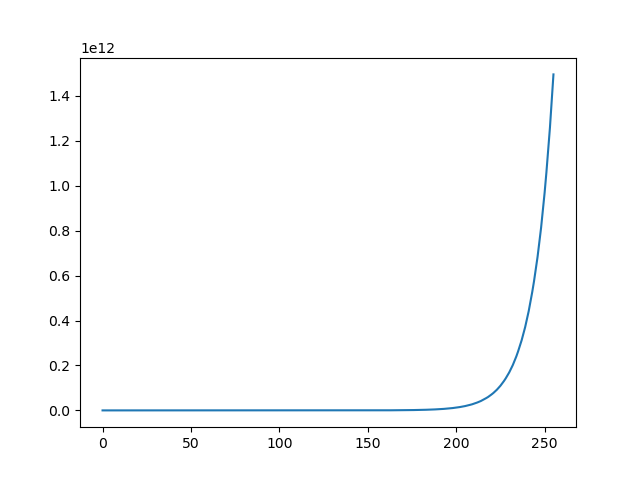

In [12]:
def generator(fish_timer, days):
    for i in range(days):
        yield memoize_numpy(fish_timer, i)

y = [x for x in generator(fish_timer, 256)]

fig, ax = plt.subplots()
ax.plot(y)
plt.show()

Ovaj brzi rast oko ~200 je onaj 'Ajoj.....' nakon čitanja drugog podzadatka

### Rješenje pomoću vulgaris python-a :)

(Jer ja volim vulgaris python)

In [13]:
with open('2021_6_input.txt') as f:
    inlist = list(map(int, f.readline().strip().split(',')))
d = deque([0 for _ in range(9)])
for num in inlist:
    d[num] += 1

In [14]:
def memoize_pure_python(deq, days):
    d = deque([x for x in deq])
    for _ in range(days):
        d[7] += d[0]
        d.rotate(-1)
    return sum(d)

In [15]:
print(memoize_pure_python(d, 80))
print(memoize_pure_python(d, 256))

362346
1639643057051


## Experimental Emergency Teleportation
*[Link na zadatak](https://adventofcode.com/2018/day/23)*

Ovo se naizgled čini kao relativno jednostavan zadatak. Imamo ulazne podatke zapisane u lijepom formatu (regex ftw :), proparsiramo ih, napravimo duplu petlju po svim točkama i pamtimo informaciju o koliko točaka ima u radiusu.

In [16]:
import re
from collections import Counter

def parse_line(line):
    return tuple(map(int, re.match(r'pos=<(-?\d+),(-?\d+),(-?\d+)>, r=(\d+)', line).groups()))

def manh_dist(point1, point2):
    return sum(abs(point1[i] - point2[i]) for i in range(3))

inlist = get_aoc_input(session, 23, 2018, return_output=True)
inputs = [parse_line(line) for line in inlist]
c = Counter()
for n1 in inputs:
    for n2 in inputs:
        if manh_dist(n1,n2) <= n1[-1]:
            c[n1] += manh_dist(n1,n2) <= n1[-1]

n = sorted(c.keys(), key=lambda x: x[-1], reverse=True)[0]
print(c[n])

420


Drugi dio zadatka je već problem :(
Ono što nas autor zadatka traži je naći točku (ne samo iz liste točaka iz inputa, već u cijelom prostoru) koja se nalazi u radiusu najviše nanobota. 
Ako je netko bacio oko na input podatke, vidio bi nešto tipa:
```
pos=<103290942,42471093,43305198>, r=97952018
pos=<-9203818,54725315,72095008>, r=58880343
```
Ovakvih koordinata ima točno 1000. Po uputama zadatka, mi se nalazimo na poziciji `(0,0,0)`. Kratka matematika nam kaže da ovo ne možemo računati za svaku točku u koordinatnom sustavu. Moramo raditi nešto tipa divide and conquer ili nekakvo binarno pretraživanje. Tko želi neka pokuša, al meni je to malo prekomplicirano, ovo možemo riješiti na jednostavniji način.

Ovo je dobro vrijeme da predstavim jedan predivan python paket koji se zove `z3-solver` (*[github](https://github.com/Z3Prover/z3)*). Za onog koga više zanima, može pratiti linkove po github-u, za one koje ne zanima, z3 je SMT (Satisfiability Modulo Theories) solver. Ono što to nama, konkretno za ovaj problem, znači je da mi možemo reći solveru što mi tražimo, koje uvijete to treba zadovoljit i koji su podatci (input). Nakon toga mu kažemo "daj mi nađi točku koja to zadovoljava ako takva točka postoji" i tjt.

In [17]:
from z3 import *

def zabs(x):
    return If(x >= 0,x,-x)

(x,y,z) = (Int('x'),Int('y'),Int('z'))
in_ranges = [Int(f'in_range_{i}') for i in range(len(inputs))]
range_count = Int('sum')
dist_from_zero = Int('dist')

o = Optimize()
for i in range(len(inputs)):
    nx,ny,nz,nr = inputs[i]
    o.add(in_ranges[i] == If(zabs(x-nx) + zabs(y-ny) + zabs(z-nz) <= nr, 1, 0))   
o.add(range_count == sum(in_ranges))
o.add(dist_from_zero == zabs(x) + zabs(y) + zabs(z))

Iznad sam rekao solveru sa kakvim podatcima radi, koje su mu varijable. `Optimize` klasu koristim kako bi riješio problem. U for petlji iznad `nx, ny, nz, nr` su kao konstante solveru, dok su `x,y,z` varijable po kojima će on pretraživat.

In [18]:
h1 = o.maximize(range_count)
h2 = o.minimize(dist_from_zero)
print(o.check())
print(o.lower(h2), o.upper(h2))

sat
124276103 124276103


Minimiziramo po udaljenosti od ishodišta, maksimiziramo po broju nanobota kojima smo unutar radiusa. Puno jednostavnije od algoritamskog pakla kroz koji bi prošli da smo ovo išli rješavat bez `z3-solver` paketa.

## Smoke Basin

*[Link na zadatak](https://adventofcode.com/2021/day/9)*

Ovaj zadatak ima neku površinu koja je definirana preko matrice brojeva $\{0,\ldots,9\}$ koji predstavljaju neku visinu. Prvi dio zadatka traži da nađemo tzv `low points`. točka je `low point` ako je okružena (gore, dolje, lijevo, desno) sa točkama veće vrijednosti. Mi trebamo naći `risk level` $R$ koji je definiran
$$
R = \sum_{low \in L} low + 1
$$
gdje je $L$ skup svih točaka koje su `low points`.

In [19]:
inlist = get_aoc_input(session, 9, 2021, return_output=True)
matrix = [[int(x) for x in line] for line in inlist]
matrixes = np.array([[[int(x) for x in line] for line in inlist]])

Ovaj zadatak ću riješiti tako da ću za svaku točku u matrici provijeriti dali je ona `low point` i ako je spremit ću ju u listu `lows` (potrebno kasnije) i povečavati `risk_level`.

Funkcija `check_low_spots` provjerava dali je točka `low_point`. Dodatna ifologija sa `matrix` objektom je za animaciju kasnije.

In [20]:
def check_low_spot(i,j,inlist,matrix):
    ok = True
    for (x,y) in [(1,0), (0,1), (-1,0), (0,-1)]:
        if -1 < y + j < len(inlist) and -1 < x + i < len(line):
            ok &= int(inlist[y+j][x+i]) > int(l)
    if ok:
        matrix[j][i] = 0
        return matrix, 1+int(l)
    else:
        matrix[j][i] = 6 if matrix[j][i] != 9 else 9
        return None, None

In [21]:
lows,risk_level = [],0
for j,line in enumerate(inlist):
    for i,l in enumerate(line):
        m, n = check_low_spot(i,j,inlist,matrix)
        if m is not None:
            risk_level += n
            lows.append((i,j))
            matrixes = np.append(matrixes, [m], axis=0)
print(risk_level)

558


Još jedan lagani prvi dio zadatka (mislim da možete uočiti neki uzorak tu :). Drugi zadatak uvodi pojam `basin`. `basin` je skup točaka koje se "slijevaju" u jedan `low point` (tu dolazi lista `lows` u igru) (mislim da je najbolja hrvatska rijec za basin bazen pa ću to koristit dalje). Trebamo naći 3 največa bazena i vratiti produkt njihovih veličina. Veličina bazena je definirana kao suma svih vrijednosti točaka koje čine taj bazen (točke sa brojem 9 nisu dio niti jednog bazena). Vrijedi da je svaka točka (osim onih sa vrijdnosti 9) dio točno jednog bazena.

Jako je bitan dio `točke sa brojem 9 nisu dio niti jednog bazena`. Koristeći tu informaciju i uvjete zadatka, lako se odredi jedan bazen (okružen je sa točkama vrijednosti 9 i svaka točka iz liste `lows` je iz jednog bazena). Bazen možemo odrediti `BFS` algoritmom. *[Link](https://en.wikipedia.org/wiki/Breadth-first_search)* za one koji nisu sigurni što je `BFS`. Početak pretraživanja su nam točke iz liste `lows` koje smo našli u prethodnom zadatku.

In [22]:
def basin_size(x,y,inlist):
    seen = set()
    Q = [(x,y)]
    size = 0
    while len(Q) > 0:
        curr = Q.pop(0)
        curx, cury = curr
        if curr in seen:
            continue
        seen.add(curr)
        if 0 <= cury < len(inlist) and 0 <= curx < len(inlist[0]):
            if int(inlist[cury][curx]) != 9:
                size += 1
                Q += [(curx+1,cury), (curx-1,cury), (curx,cury+1), (curx,cury-1)]
    return size

Proiteriramo po svim točkama iz `lows`, prikupimo veličine bazena i sortiramo ih.

In [23]:
basins = []
for (x,y) in lows:
    basins.append(basin_size(x,y,inlist))
basins.sort()
print(f'Size of the largest three basins: {basins[-1]}, {basins[-2]}, {basins[-3]}')
print(f'Those numbers multiplied: {basins[-1] * basins[-2] * basins[-3]}')

Size of the largest three basins: 101, 94, 93
Those numbers multiplied: 882942


Ovo su samo neke sitnice za animaciju. Iz animacije se lijepo vide svi bazeni i `low points` bazena

<IPython.core.display.Javascript object>


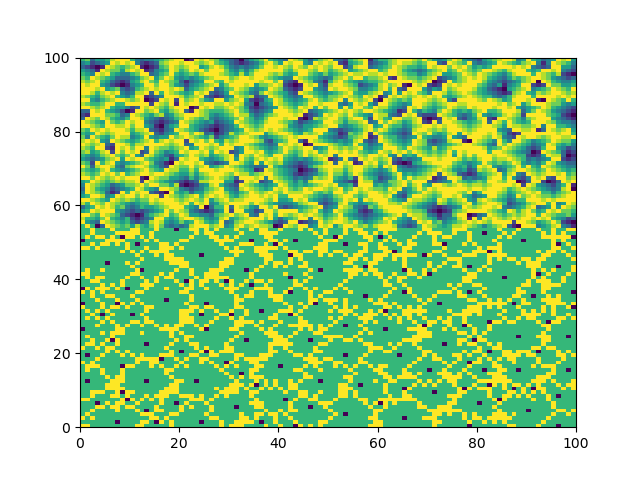

In [24]:
fig, ax = plt.subplots()
cax = ax.pcolormesh(matrixes[0, :, :])

def basin_animate(i):
    cax.set_array(matrixes[i, :, :])
    return cax

anim = animation.FuncAnimation(fig, basin_animate, interval=100, frames=matrixes.shape[0] - 1)
plt.show()

## Jurassic Jigsaw

*[Link na zadatak](https://adventofcode.com/2020/day/20)*

Ovaj zadatak je daleko najteži zadatak u eseju.... Sretno sa čitanjem :)

Input nam je niz matrica sastavljenih od znakova `.` i `#`. Svaka matrica ima svoj `ID`. Matrice predstavljaju puzle koje, jednom kad ih složimo, ce sadržavati sliku čudovišta. Ove puzle slažemo tako da nađemo rubove koji se podudaraju, sa time da kod ovih puzli rubovi moraju biti isti ako se puzle podudaraju. Npr.
```
#  #
.  .
.  .
#  #
```
Ova dva ruba se podudaraju.
Prvi dio zadatka traži da nađemo `ID` rubnih puzli i vratimo njihov produkt.

Ispod učitavamo input u `dict` `tiles`. Kljucevi su `ID` puzli, a vrijednosti su puzle, s time da zamijenimo znak `.` sa `0` i `#` sa `1` (bit će potrebno kod drugog podzadatka i za plotanje).

In [25]:
get_aoc_input(session, 20, 2020)

with open('2020_20_input.txt') as f:
    tiles = {
        int((line := tile.split('\n'))[0].split()[1][:-1]) : np.array([[int(x) for x in y] for y in line[1:]])
        for tile in f.read().replace('.','0').replace('#','1').split('\n\n')
    }

Za prvi dio ne trebamo složiti cijelu sliku, trebamo samo naći rubne puzle. Rubovi će imati točno 2 susjeda (susjed == rubovi im se poklapaju). To možemo postići lako sa skupovima.

`edges` je `dict` gdje su `key == ID`, a `value` je skup svih rubova i istih rubova obrnutih puzle.

`neighbors` je `dict` koji povezuje puzle sa istim rubovima.

`corners` je lista `ID`-jeva rubnih puzli. Odgovor na prvi podzadatak je produkt elemenata te liste.

In [26]:
from functools import reduce

edges = {
    k : set.union(*[{tuple(edge), tuple(reversed(edge))} for edge in [v[0], v[-1], v[:,0], v[:,-1]]])
    for k, v in tiles.items()
}
neighbors = {
    k1 : ({k2 for k2, v2 in edges.items() if v1 & v2} - {k1}) for k1,v1 in edges.items()
}
corners = [k for k, v in neighbors.items() if len(v) == 2]

print(reduce(lambda a,b: a * b, corners))

17148689442341


`edges` i `neighbors` `dict`-ovi će nam biti potrebni i kasnije kod slaganja puzli.

Funkcija ispod nam je potrebna za slaganje puzli kako bi uspijeli naći susjede svakoj puzli. Numpy ftw.

In [27]:
def rotations(tile):
    for _ in range(2):
        for _ in range(4):
            tile = np.rot90(tile)
            yield tile
        tile = np.flip(tile,0)

Puzle slažemo tako da počnemo od nekog ruba i slažemo ovako:
```
 1   2   3   4
 8   7   6   5
 9  10  11  12
16  15  14  13
```
gdje brojevi $\{1,\ldots,16\}$ predstavljaju poredak stavljanja puzli.

In [28]:
current = corners[0]
reverse = False
tiles[current] = next(
    tile for tile in rotations(tiles[current]) 
    if {tuple(tile[-1]), tuple(tile[:,-1])}.issubset(
        set.union(*[edges[k] for k in neighbors[current]])
    )
)
chart = []
chart_row = [tiles[current][1:-1,1:-1]]
chart_with_edges = []
chart_row_with_edges = [tiles[current]]

Funkcije `find_next_tile` i `get_next_tile` nam pomažu u slaganju puzli.

`find_next_tile` traži `ID` u `dict`-u susjeda trenutne pločice. Funkcija takoder prima konkretan rub puzle (više o tome ispod), pa moramo od susjeda odabrat onog koji ima točno takav rub.
Ako uspijemo naći puzlu (tj. njen `ID`) spremamo rotaciju nađene puzle u `dict` `tiles` tako da se rub te puzle i trenutne puzle podudaraju.

In [29]:
def find_next_tile(current, current_edge, reverse, row):
    next_tile = [k for k in neighbors[current] if tuple(current_edge) in edges[k]]
    if len(next_tile) > 0:
        tiles[next_tile[0]] = [
            tile for tile in rotations(tiles[next_tile[0]]) 
            if tuple(current_edge) == (tuple(tile[:,-int(reverse)]) if row else tuple(tile[0]))
        ][0]
        return next_tile[0]
    return None

`get_next_file` poziva `find_next_tile` (loša nomenklatura sa moje strane...ne ide mi inače) i ako dobije nazad neki `ID`, on postaje trenutni, a puzla ide u niz `chart_row`.

Mala digresija... varijabla `current_edge` koju prima funkcija `find_next_file` je rub trenutne puzle. Funkcija `get_next_tile` uvijek pokuša prvo naći susjednu puzlu trenutnoj pomoću lijevog/desnog ruba (redosljed pretraživanja je gore). Dali je rub lijevi ili desni sami određujemo pomoću varijable `reverse` koju negiramo svaki put kad dođemo do kraja reda koji popunjavamo. Ako nam `find_next_file` vrati `None`, znači da smo udarili u rub reda koji popunjavamo i moramo tražiti susjeda preko donjeg ruba. To radimo u `else` bloku.
Jednom kad nađemo puzlu, vratimo njen `ID`.

In [30]:
def get_next_tile(current, chart, chart_row, cwe, crwe, reverse, row=True):
    next_tile_id = find_next_tile(current, tiles[current][:,-(not reverse)] if row else tiles[current][-1], reverse, row)
    if next_tile_id:
        current = next_tile_id
        chart_row += [tiles[current][1:-1,1:-1]]
        crwe += [tiles[current]]
    else:
        if len(chart_row) == 0: return next_tile_id
        chart += [np.hstack(chart_row)] if not reverse else [np.hstack(chart_row[::-1])]
        cwe += [np.hstack(crwe)] if not reverse else [np.hstack(crwe[::-1])]
        chart_row.clear()
        crwe.clear()
    return next_tile_id

Ispod je petlja u kojoj slažemo puzlu. Kad `current` postane `None` znamo da smo složili puzlu.

<IPython.core.display.Javascript object>


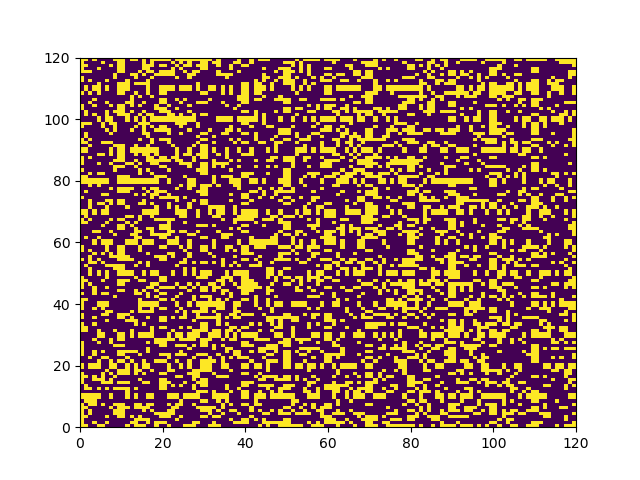

In [31]:
while current:
    next_tile_id = get_next_tile(current, chart, chart_row, chart_with_edges, chart_row_with_edges, reverse)
    if next_tile_id is None:
        reverse = not reverse
        current = get_next_tile(current, chart, chart_row, chart_with_edges, chart_row_with_edges, reverse, row=False)
    else:
        current = next_tile_id
        
chart = np.vstack(chart)
chart_with_edges = np.vstack(chart_with_edges)
fig, ax = plt.subplots()
cax = ax.pcolormesh(chart_with_edges)

Na plot-u iznad možda uspijete vidjet malo dulje vodoravne i okomite žute blokove. To su dva ruba koja se podudaraju. Plot predstavlja složenu puzlu sa rubovima. U ostatku zadatka nam treba puzla bez rubova.

Drugi podzadatak nas traži da pronađemo sva čudovišta u slici koju smo dobili iz slaganja puzli i vratimo broj ćelija sa znakom `#` koje nisu dio nekog čudovišta. Tu će nam pomoći ono pretvaranje `.` u `0` i `#` u `1`. Kako bi našli čudovište, prolazimo kroz sve rotacije puzle i koristimo lijepe numpy maske. Znamo da smo našli čudovište ako je broj brojeva jednak 2 u toj `len(nessie) x len(nessie[0])` matrici jednak 15. Postavljanje tih ćelija na 10 je samo za plotanje kasnije.

In [32]:
nessie = np.array([[int(x) for x in y] for y in ('''
                  # 
#    ##    ##    ###
 #  #  #  #  #  #   
'''.replace(' ', '0').replace('#','1').split('\n')[1:-1])])

def scan(chart, nessie):
    nessies = 0
    for i in range(len(chart) - len(nessie)):
        for j in range(len(chart[0]) - len(nessie[0])):
            area = (chart[i : i + len(nessie), j : j + len(nessie[0])] + nessie)
            if len(area[area == 2]) == 15:
                for k in range(i, i + len(nessie)):
                    for l in range(j, j + len(nessie[0])):
                        if nessie[k - i][l - j] == 1: chart[k][l] = 10
                nessies += 1
    return nessies

Pošto smo ćelije sa `1` koje su dio nekog čudovišta zamijenili sa `10`, samo trebamo naći sumu ćelija koje imaju `1`. To je riješenje drugog podzadatka.

Broj čudovišta: 29
Rj drugog podzadatka: 2009


<IPython.core.display.Javascript object>


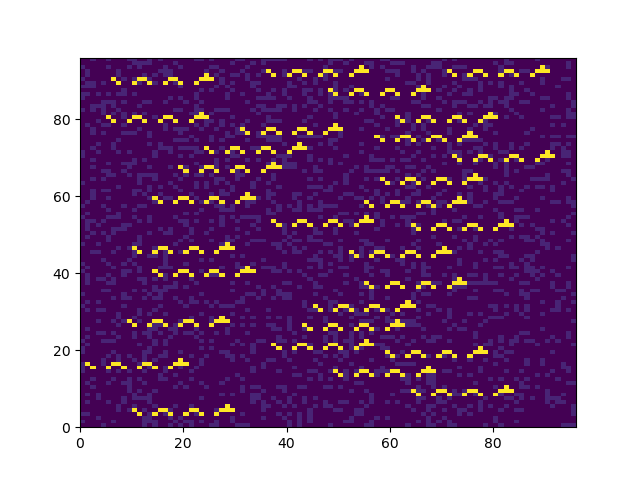

In [33]:
for rot in rotations(chart):
    if (nessies := scan(rot, nessie)) > 0:
        print(f'Broj čudovišta: {nessies}')
        print(f'Rj drugog podzadatka: {sum(chart[chart == 1])}')
        rot = np.fliplr(np.flip(rot))
        fig, ax = plt.subplots()
        cax = ax.pcolormesh(rot)
        break

# Sea Cucumber

*[Link na zadatak](https://adventofcode.com/2021/day/25)*

Ovo je primjer zadatka koji se dobije na Božic. Tu zapravo postoji samo jedan podzadtak.

Ovo je relativno jednostavan zadatak, ali ima jako zanimljivu pozadinu. Zadatak je zapravo *[Biham–Middleton–Levine traffic model](https://en.wikipedia.org/wiki/Biham%E2%80%93Middleton%E2%80%93Levine_traffic_model)*.

U zadatku imamo matricu znakova `>`, `v` i `.`. Trebamo napraviti simulaciju po pravilima u zadatku. Pravila kažu da se ćelije `>` mogu micati samo u desno i to samo ako je polje desno od njih prazno. Analogno za `v`. Prvo se pomiću svi `>`, a potom svi `v`. Pomicanje je modulo dimenziju (čitaj: tko prijeđe rub, vraća se na početak). Traži se korak u kojem niti jedna ćelija ne može pomaknuti.

In [34]:
inlist = get_aoc_input(session, 25, 2021, return_output=True)
d, dd = {}, {}
for i,line in enumerate(inlist):
    for j,char in enumerate(line):
        d[(i,j)] = char
dir_map = {'>' : 4, 'v' : 7, '.' : 0}
cucumber_matrix = [[dir_map[x] for x in line] for line in inlist]
move_map = {'>' : (0,1), 'v' : (1,0)}
len_row, len_col = len(inlist), len(inlist[0])

Catch u ovom zadatku je `prvo pomaknite sve > a onda sve v` dio. Jako lako se osoba tu može zeznut (znam iz iskustva :). Zato tu radimo deep kopije matrice.

In [35]:
def move_cucumber(direction, d, dd, cucumber_matrix):
    global dir_map, move_map, len_row, len_col
    moved = False
    for i in range(len_row):
        for j in range(len_col):
            k,l = (i + move_map[direction][0]) % len_row, (j + move_map[direction][1]) % len_col
            if d[(i,j)] == direction and d[(k,l)] == '.':
                dd[(i,j)] = '.'
                dd[(k,l)] = direction
                cucumber_matrix[i][j] = 0
                cucumber_matrix[k][l] = dir_map[direction]
                moved = True
    return dd, moved

In [36]:
def next_step(direction, d, dd):
    global matrix_list, cucumber_matrix
    dd = {k:v for k,v in d.items()}
    dd, moved = move_cucumber(direction, d, dd, cucumber_matrix)
    matrix_list = np.append(matrix_list, [cucumber_matrix], axis=0)
    return d, dd, moved

Iteriramo po svim koracima dok ne detektiramo da nije došlo do ikakve promjene u matrici. To pratimo sa varijablom `moved`.

In [37]:
step = 0
matrix_list = np.array([[[dir_map[x] for x in line] for line in inlist]])
while True:
    d, dd, moved = next_step('>', d, dd)
    dd, d, moved2 = next_step('v', dd, d)
    if not moved and not moved2:
        break
    step += 1
print(step + 1)

518


<IPython.core.display.Javascript object>


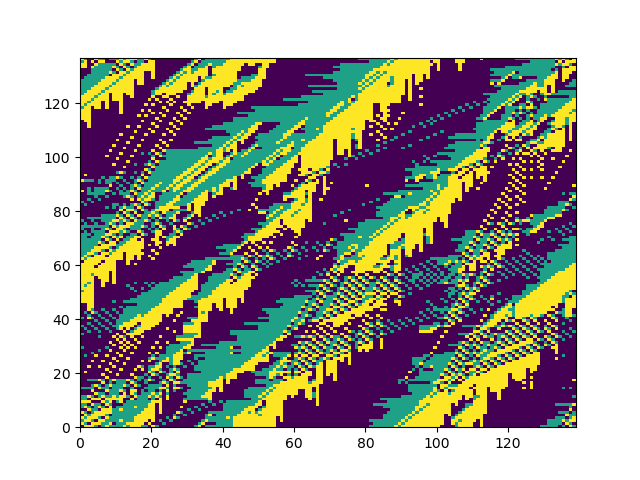

In [38]:
def cucumber_animate(i):
    cax.set_array(matrix_list[i, :, :])
    return cax

fig, ax = plt.subplots()
cax = ax.pcolormesh(matrix_list[0, :, :])

anim = animation.FuncAnimation(fig, cucumber_animate, interval=10, frames=matrix_list.shape[0] - 1)
plt.show()